In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn as sns
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = ('/content/drive/MyDrive/Skin_Disease/train')
test_path = ('/content/drive/MyDrive/Skin_Disease/test')
valid_path = ('/content/drive/MyDrive/Skin_Disease/valid')

In [ ]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
#new_train_path = ('/content/drive/MyDrive/Skin_Disease/new_train')
#validation_path = ('/content/drive/MyDrive/Skin_Disease/new_test/Warts Molluscum and other Viral Infections')
#new_test_path = ('/content/drive/MyDrive/Skin_Disease/new_test')

In [ ]:
#train_ratio = 0.6  # 60% for new training
#validation_ratio = 0.2  # 20% for validation
#test_ratio = 0.2  # 20% for testing

In [ ]:
#os.makedirs(new_train_path, exist_ok=True)
#os.makedirs(validation_path, exist_ok=True)
#os.makedirs(new_test_path, exist_ok=True)

In [ ]:
# List the files in the train directory
#train_files = os.listdir(train_path)

In [ ]:
#for filename in train_files:
 #   src_file_path = os.path.join(train_path, filename)
  #  rand = random.random()  # Generate a random number between 0 and 1

In [ ]:
# Determine which directory to copy the file to based on the split ratio
#if rand < train_ratio:
 # dst_file_path = os.path.join(new_train_path, filename)
#elif rand < train_ratio + validation_ratio:
 # dst_file_path = os.path.join(validation_path, filename)
#else:
 #dst_file_path = os.path.join(new_test_path, filename)

In [ ]:
#shutil.copytree(src_file_path, dst_file_path)

In [ ]:
# Validation data generator
#validation_datagen = ImageDataGenerator(
 #   rescale=1.0 / 255  # Rescale pixel values to [0, 1]
##)


In [ ]:
#validation_generator = validation_datagen.flow_from_directory(
    #validation_path,
    #target_size=(224, 224),
    #batch_size=20,
    #class_mode='categorical',  # Change to 'binary' for binary classification
    #shuffle=False  # No need to shuffle the validation data
#)

In [ ]:
#Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_path, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))


# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( valid_path,  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 15589 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False  # No need to shuffle the test data
)

Found 4002 images belonging to 23 classes.


In [ ]:
imgs, labels = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


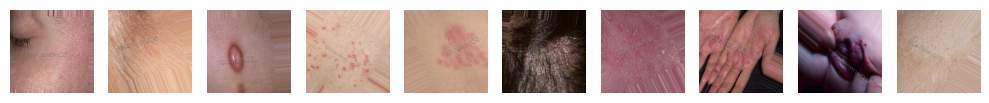

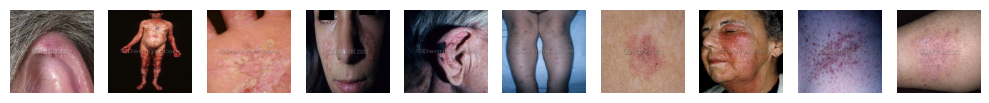

In [ ]:
plotImages(imgs)
imgs, labels = next(validation_generator)
plotImages(imgs)
#print(labels)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:



# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Change the number of units in the final output layer to match the number of classes (e.g., 5)
num_classes = 23  # Number of classes
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Use softmax activation for multi-class classification

model = tf.keras.models.Model(base_model.input, x)

# Change the loss function to categorical cross-entropy
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Fit the model
from tensorflow.keras.callbacks import ModelCheckpoint  # Import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Skin_Disease/My_Model.h5',  # Specify the path and filename
    monitor='val_acc',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to maximize the monitored quantity (validation accuracy)
    verbose=1  # Display messages about the checkpointing process
)

# Train the model and save training history

#vgghist = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=1)

In [ ]:
num_classes = 23  # Number of classes in your dataset
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [ ]:
# Train the model and save training history
vgghist = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=10,
    callbacks=[model_checkpoint]  # Pass the callback for model checkpointing
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 3.1442 - acc: 0.1091 
Epoch 1: val_acc improved from -inf to 0.16592, saving model to /content/drive/MyDrive/Skin_Disease/My_Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 4374s 44s/step - loss: 3.1442 - acc: 0.1091 - val_loss: 2.8764 - val_acc: 0.1659
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 2.9546 - acc: 0.1320 
Epoch 2: val_acc improved from 0.16592 to 0.17841, saving model to /content/drive/MyDrive/Skin_Disease/My_Model.h5
100/100 [==============================] - 1345s 13s/step - loss: 2.9546 - acc: 0.1320 - val_loss: 2.8306 - val_acc: 0.1784
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 2.9097 - acc: 0.1420 
Epoch 3: val_acc did not improve from 0.17841
100/100 [==============================] - 1168s 12s/step - loss: 2.9097 - acc: 0.1420 - val_loss: 2.7871 - val_acc: 0.1749
Epoch 4/10
 28/100 [=======>......................] - ETA: 11:48 - loss: 2.8679 - acc: 0.1625

In [ ]:
#Save the Model
model.save('/content/drive/MyDrive/Skin_Disease/My_Model.h5')
print('Model saved as /content/drive/MyDrive/Skin_Disease/My_Model.h5')

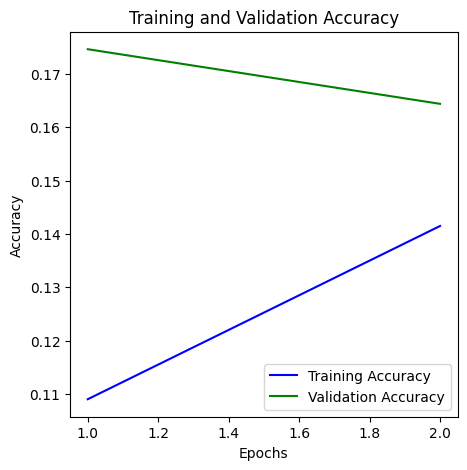

In [ ]:
#Plot Training & Validation accuracy & loss graph

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image  # Corrected import
from tensorflow.keras.models import load_model
# Save the trained model as a .h5 file in Google Drive


# Plot training and validation accuracy
acc = vgghist.history['acc']
val_acc = vgghist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(5, 5))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Load a custom image for testing
custom_image_path = '/content/drive/MyDrive/Skin_Disease/test/Acne and Rosacea Photos/07PerioralDermEye.jpg'
img = image.load_img(custom_image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
#prediction = [0,0,1,0,0].index(1)
# Make predictions on the custom image
result  = {0:"Acne and Rosacea Photos",1:"Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions",2:"Atopic Dermatitis Photos",3:"Bullous Disease Photos",4:"Cellulitis Impetigo and other Bacterial Infections",5:"Eczema Photos",6:"Exanthems and Drug Eruptions", 7:"Hair Loss Photos Alopecia and other Hair Diseases", 8:"Herpes HPV and other STDs Photos",
           9: "Light Diseases and Disorders of Pigmentation", 10: "Lupus and other Connective Tissue diseases", 11: "Melanoma Skin Cancer Nevi and Moles", 12: "Nail Fungus and other Nail Disease", 13: "Poison Ivy Photos and other Contact Dermatitis", 14: "Psoriasis pictures Lichen Planus and related diseases", 15: "Scabies Lyme Disease and other Infestations and Bites",
           16: "Seborrheic Keratoses and other Benign Tumors", 17: "Systemic Disease", 18: "Tinea Ringworm Candidiasis and other Fungal Infections", 19: "Urticaria Hives", 20: "Vascular Tumors", 21: "Vasculitis Photos", 22: "Warts Molluscum and other Viral Infections"}
prediction = model.predict(img)
prediction_index = np.argmax(result)
Prediction = result[prediction_index]
print(prediction, " ", prediction_index, " ",Prediction)
# m=0
# for x in prediction[0]:
#     if x>=1:
#       m = prediction[0].index(x)
#       break

# print(f"Custom Image Prediction: {m} :- {result[m]}")

# Display the custom image
plt.figure()
plt.imshow(image.load_img(custom_image_path, target_size=(150, 150)))
plt.title(f'Custom Image Prediction: {result}')

plt.show()